# Business Understanding

Our business problem is that SyriaTel, a telecommunications company, would like to reduce monetary losses related to customer churn, meaning losses related to customers who do not use the company's services for very long.  Our goal with this project is to look for any predictable patterns we can ascertain from available data which might help pinpoint cause(s) of customer churn.  Then, we will make recommendations for action SyriaTel might take to reduce customer churn based on our findings.

# Data Understanding

We are working with a dataset from SyriaTel providing records for over 3,300 accounts.  We have basic information like account numbers and length, and location information in state and area code.  It includes some plan type information and the number of customer service calls, as well as minutes, calls and charges broken down by time of day and whether domestic or international.

In [130]:
#importing the data and getting an idea of what information it contains

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('SyriaTelDATA.csv.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [131]:
# seeing what value formats look like

df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


No null values!  We do have a few categorical features to deal with.  Phone number is probably not useful to our analysis.  We have two location features in state and area code.  Since there are lots of outside variables which might impact any correlation to location, it's best to focus first on items which stakeholder possesses the most control over.  We also have call data to include minutes, calls, and charges broken down by day, evening, night, and international.  Minutes and charges seem important while the number of calls (how the minutes are broken down by call) probably matters less, so we'll simplify things by dropping those calls features as well.  The only exception we will keep is customer service calls.  Intuitively, that seems like it could be a highly correlated feature.

# Data Preparation

Preparing the data involves removing unnecessary and redundant columns which we don't need for our business question, as well as removing some highly correlated features to reduce multicollinearity (for example, daytime calls, minutes, and charges are all correlated so we can make do with one rather than 3).  We also change some datatype sin order to perform modeling with them.

In [132]:
# dropping unnecessary or redundant columns and changing some datatypes

df = df.drop(['state', 'phone number', 'area code', 'number vmail messages', 'total day calls', 'total day minutes', 'total eve calls', 'total eve minutes', 'total night calls', 'total night minutes', 'total intl calls', 'total intl minutes'], axis=1)
df['international plan'] = df['international plan'].replace({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].replace({'yes': 1, 'no': 0})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   international plan      3333 non-null   int64  
 2   voice mail plan         3333 non-null   int64  
 3   total day charge        3333 non-null   float64
 4   total eve charge        3333 non-null   float64
 5   total night charge      3333 non-null   float64
 6   total intl charge       3333 non-null   float64
 7   customer service calls  3333 non-null   int64  
 8   churn                   3333 non-null   bool   
dtypes: bool(1), float64(4), int64(4)
memory usage: 211.7 KB


In [133]:
# checking the target variable for any class imbalance

print(df['churn'].value_counts())
print(df['churn'].value_counts(normalize=True))

False    2850
True      483
Name: churn, dtype: int64
False    0.855086
True     0.144914
Name: churn, dtype: float64


In [134]:
categoricals = ['international plan', 'voice mail plan']
dummies = pd.get_dummies(df[categoricals], drop_first=True)

df = df.drop(categoricals, axis=1)

df = pd.concat([df, dummies], axis=1)

df.head()

,account length,total day charge,total eve charge,total night charge,total intl charge,customer service calls,churn,international plan,voice mail plan
0,128,45.07,16.78,11.01,2.70,1,False,0,1
1,107,27.47,16.62,11.45,3.70,1,False,0,1
2,137,41.38,10.30,7.32,3.29,0,False,0,0
3,84,50.90,5.26,8.86,1.78,2,False,1,0
4,75,28.34,12.61,8.41,2.73,3,False,1,0


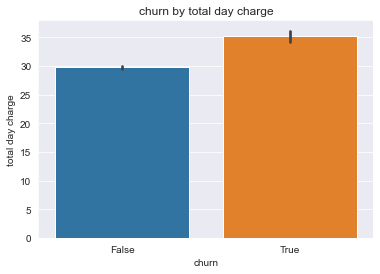

In [135]:
# plotting churn by daytime charge

def barplot(yaxis):
    sns.barplot(data=df, y=yaxis,x='churn')
    plt.title(f'churn by {yaxis}')

barplot('total day charge')
plt.savefig("churn_by_day_charge.png")

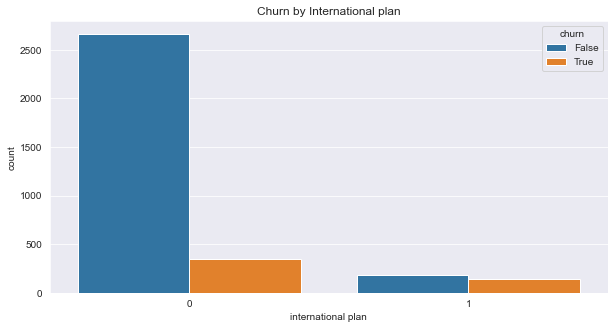

In [136]:
# plotting churn by international plan

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='international plan', hue='churn')
plt.title("Churn by International plan");

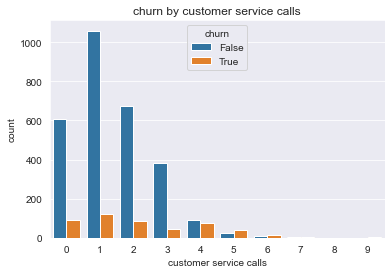

In [137]:
# plotting churn by customer service calls

sns.countplot(data=df, x='customer service calls', hue='churn')
plt.title("churn by customer service calls");
plt.savefig("churn_by_CScalls.png")

In [138]:
# scaling data

categorical_features = X.select_dtypes(include='O').columns
numerical_features = X.select_dtypes(include=['int','float']).columns


log_transformer = FunctionTransformer(np.log1p)

transformer = ColumnTransformer([
    ('ohe',OneHotEncoder(handle_unknown='ignore'),categorical_features), #Encode categorical variables
    ('log_transform',log_transformer,['total intl calls','customer service calls']), #log transformation on skewed data
    ('scaler',StandardScaler(),numerical_features) #scale numerical features
])

There is siginificant class imbalance of the target variable with 85+% of the data as the negative case.

# Modeling and Evaluation

I will begin with a baseline logistic regression model and balance the classes of the target variable.

In [139]:
y = df['churn'].astype(int)
X = df.drop('churn', axis=1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [140]:
logreg = LogisticRegression(fit_intercept=False, class_weight='balanced', solver='liblinear')

AUC: 0.7525514209452034


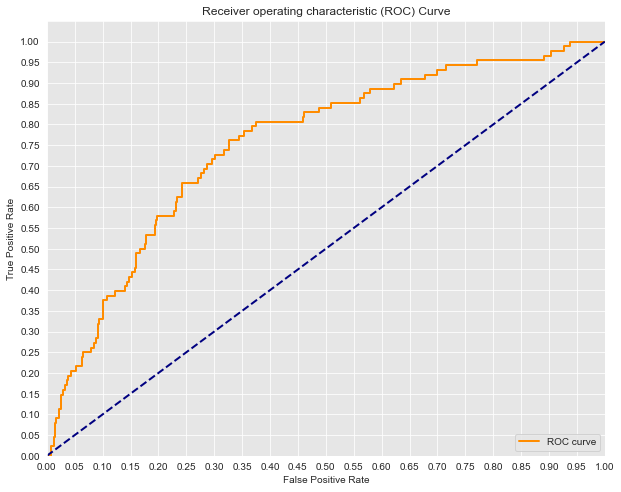

In [141]:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC (area under curve)

print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw=lw, label='ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw=lw, linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [142]:
y_pred = logreg.predict(X_test)

In [143]:
# looking at confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[392, 187],
       [ 23,  65]])

In [144]:
# evaluating by recall score

recall_score(y_test, y_pred)

0.7386363636363636

In [145]:
# fit decision tree model

clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

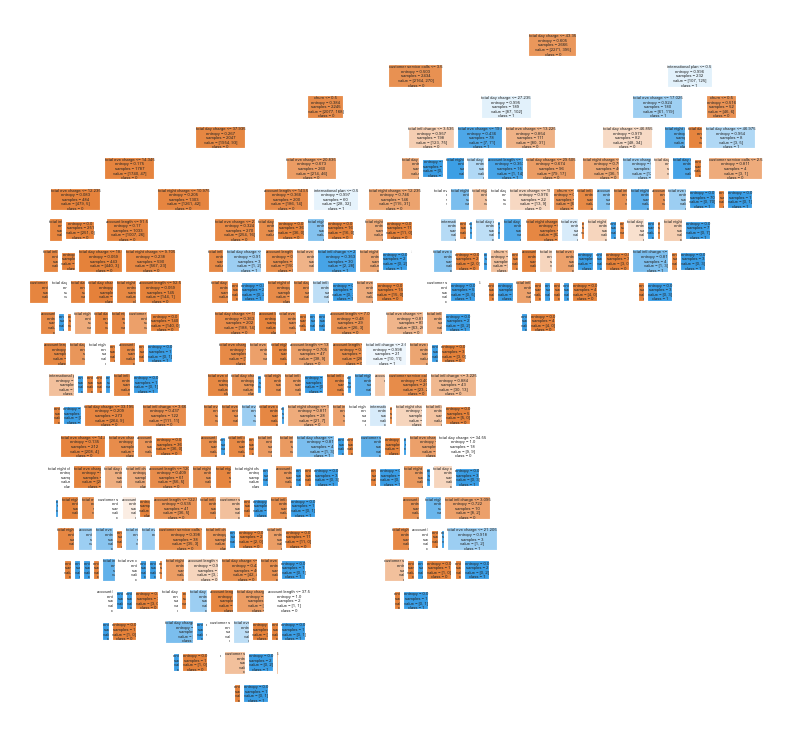

In [146]:
# plotting decision tree

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = df.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [147]:
# prediction and recall score

y_preds = clf.predict(X_test)

print ('Recall: ', recall_score(y_test, y_preds))

Recall:  0.7613636363636364


In [148]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7078328623017742

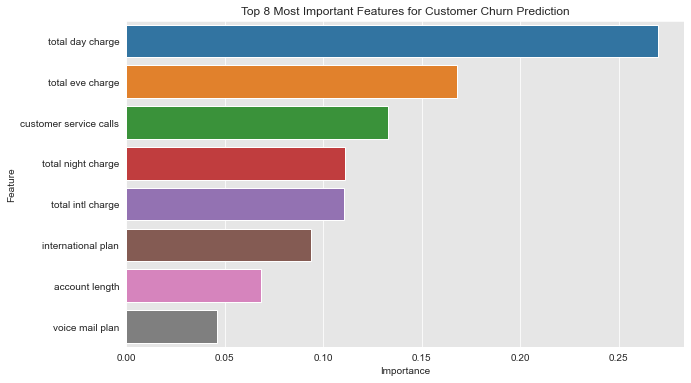

In [158]:
# identifying which features contribute most to churn

feature_importances = clf.feature_importances_

# Creating a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# sort in descending order for better interpretability in visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plotting bar graph showing importance of our chosen features
top_n = 8
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
plt.title(f'Top {top_n} Most Important Features for Customer Churn Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig("importance.png")
plt.show()

# Conclusion

We analyzed Syriatel's data to identify any patterns which might indicate that a customer may soon churn.  We prioritized minimizing false negatives, meaning we want to avoid incorrectly predicting a customer will not churn, when in fact the customer did churn.  This scenario represents the most expensive outcome, since retaining current customers is well known to be less costly than acquiring new customers.  While me may mistakenly identify a customer would churn when in fact they would not have, any resources deployed to keep that customer would still serve to improve their loyalty to the company, even if it was technically a waste of resources.  Losing a current customer comes at a much hugher cost to the company.

We deployed Logistic Regression and Decision Tree models on our data, finding the decision tree model to perform best by recall score.

The model helped us confirm the top factors determining customer churn: charges with day charges in particular being significant, as well as customer service calls.

## Limitations

It is difficult to account for the possibility that customer behavior was impacted by outside variables not represented in the data.  SyriaTel promotions or lack thereof, or policy changes could impact customers' tendency to churn.  Promotions of competitor telecom companies might impact churn as well.

## Recommendations

We would recommend a customer retention strategy which targets current customers who are heavy users of daytime minutes in particular, but one that addresses the key feature of call charges broadly.  This could include personalized promotional offers like discounts on day charges which improve loyalty and therefore minimize revenue loss while still being cost effective.

Customer service quality should be evaluated for improvement since customers who made 4 or more customer service calls show higher potential to churn.  Evaluate the reasons for these calls and address this key factor driving customer churn.

Make use of predictive modeling to predict churn in real time, and flag high risk customers to apply retention stategy.

## Next Steps

It would be worth collecting additional data by way of customer satisfactions surveys.

Evaluating churn by location could be worthwhile if we have time to dedicate.